# External Data
## CityBike
Write a function that lists all the nearest citybike stations to a given location.

When starting a project like this it is useful to think about the steps required to arrive at the final solution.
in the case of the citybike example, this could look something like this:
* get the citybike data from the web
    * in particular, get the location of the stations
* calculate the distances from the station locations to a given point
* wrap and format everything nicely

### Exploring the data
first, let's check out the available data on citybikes to see what we are working with. You can also look at this in a webbrowser
but beware: [Humans should never gaze upon unfiltered data!](https://rackandstack-tech.blog/2019/11/12/the-mental-game-of-python-raymond-hettinger/)


http://dynamisch.citybikewien.at/citybike_xml.php?json

In [37]:
import requests

data = requests.get(url="http://dynamisch.citybikewien.at/citybike_xml.php?json")
data, type(data)

(<Response [200]>, requests.models.Response)

whats that Response object? what can we do with it?

we can look in the [documentation here]() or just look at the ```help(on_something_please)``` directly

In [38]:
help(data)

Help on Response in module requests.models object:

class Response(builtins.object)
 |  The :class:`Response <Response>` object, which contains a
 |  server's response to an HTTP request.
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if the status code of the response is between
 |      400 and 600 to see if there was a client error or a server error. If
 |      the status code, is between 200 and 400, this will return True. This
 |      is **not** a check to see if the response code is ``200 OK``.
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |      Allows you to use a response as an iterator.
 |  
 |  __nonzero__(self)
 |      Returns True if :attr:`status_code` is less than 400.
 |      
 |      This attribute checks if

In [39]:
data.headers['content-type']

'application/json;charset=utf-8'

The url *AND* header info on the content type suggest that the response can in fact be interpreted as json format.

As the old saying goes:
> if it looks like a duck
>
> and quacks like a duck...
>
> it probably is a duck

So let's try interpreting the response as json:

In [40]:
cb_json = data.json()

type(cb_json)=<class 'list'>
len(cb_json)=118


In [ ]:
# how many items are in there? (what's the len()gth)
len(cb_json)

so the json interpretation yields us a list with 119 entries.let's see what they hold

In [41]:
print("example: First Element: cb_json[0]")
cb_json[0]

example: Erstes Element: cb_json[0]


{'id': 108,
 'name': 'Friedrich Schmidtplatz',
 'status': 'aktiv',
 'description': 'Ecke Lichtenfelsgasse U2 Station Rathaus',
 'boxes': 24,
 'free_boxes': 12,
 'free_bikes': 12,
 'longitude': 16.356581,
 'latitude': 48.211433,
 'internal_id': 1026}

Perfect! Each element in the list is a dictionary, representing the data on a particular city bike station.
Apart from the name, status, description and how many bikes and boxes are available, we also have the positional information
on the location of the stations as latitude and longitude coordinates

To use this, we first need a way to calculate the distance between two locations.
So let's write a function, that takes two positions and returns their distance:

In [42]:
from math import sqrt

def distance(a: tuple, b: tuple):
    """
    Returns the 2D distance of 2 points represented as tuples
    :param a: tuple(x: float, y: float)
    :param b: tuple(x: float, y: float
    :return:  Distance
    """
    dx = abs(a[0] - b[0])
    dy = abs(a[1] - b[1])
    return sqrt(dx**2 + dy**2)

Let's do some tests

In [43]:
distance((0,4), (3,0))

5.0

In [1]:
distance((0,-4), (0,3))

NameError: name 'distance' is not defined

In [45]:
station1 = (cb_json[0]["longitude"], cb_json[0]["latitude"])
station2 = (cb_json[1]["longitude"], cb_json[1]["latitude"])
station1, station2

((16.356581, 48.211433), (16.37298586854365, 48.210666083418))

In [46]:
distance(station1, station2)

0.016422785177255206

It works, but what does that actually mean?

What units is the result in? Give it a minute of thought

### Distances on earth
Since latitude and longitude are actually angles on the sphere of the earth,
we need to take this into account.
We actually need to convert the difference in latitude and longitude in meters on the surface.
you remember your sin/cos and the radius of the earth, right?

Also, the earth is not actually a sphere, but an ellipsoid. That means that the closer we are to the poles,
the bigger the actual distance on the surface per angle.

So the question is: How do we calculate a distance on the earth between two coordinates?

### Python's USP
This is where the open source nature and the rich ecosystem of python really shine:
As with many other common problems, there sure is a third party library by someone who has already
solved the problem. And much better tested, and more precise than we ever could.

Quick google search "python distance latitude longitude" reveals an appropriate answer:
https://geopy.readthedocs.io/en/stable/#

In [47]:
import geopy.distance

This import statement will most likely cause an error with your vanilla python installation.
It is a third party library that first needs installation.
There are many ways of installing it, the easiest is probably:

Open a terminal/command line in your system and simply type:
```terminal
> pip install geopy
```
You should see some download bars and a success message. More on ```pip install``` here: https://realpython.com/what-is-pip/

alternatively you can use [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/installing-with-conda.html)

Once that works, let's test the module

In [48]:
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(geopy.distance.distance(coords_1, coords_2))

279.35290160430094 km


Perfect - except for the unneccessary decimal precision
Now let's try it with the citybike data.

In [49]:
geopy.distance.distance(station1, station2)

Distance(1.8172514919453264)

Now let's define a  function that takes a location and calculate the distance to each station

In [50]:
def list_nearest(location: tuple, list_of_stations):
    for station in list_of_stations:
        station_location = (station["latitude"], station["longitude"])
        dist = geopy.distance.distance(location, station_location)
        #save the ddistance in the station
        station["distance"] = round(dist.km, 1)
    list_of_stations.sort(key=lambda d: d["distance"], reverse=False)
    return list_of_stations

ok that was a little bit cheating here to sort the list according to a value in a member


Coordinates of the Energybase are
48.2696523, 16.4271389 according to google maps

And here's the nearest CityBike Stations:

In [51]:
energybase = (48.2696523, 16.4271389)
result = list_nearest(energybase, cb_json)
for i, station in enumerate(result):
    #help with enumerate: https://realpython.com/python-enumerate/
    print(f"{i+1:3}. [{station['distance']:2.1f} km] {station['name'][:20]:20s} - {station['free_bikes']:2}/{station['boxes']}")
    #help on format strings: https://realpython.com/python-f-strings/#f-strings-a-new-and-improved-way-to-format-strings-in-python

  1. [4.4 km] Millennium Tower     -  8/35
  2. [4.6 km] Friedrich Engels Pla - 10/27
  3. [5.0 km] Hellwagstraße        -  9/30
  4. [5.1 km] Traisengasse         - 13/24
  5. [5.6 km] Radingerstraße       -  4/33
  6. [5.7 km] Jägerstraße U6       - 24/26
  7. [6.0 km] Messeplatz           - 14/40
  8. [6.0 km] Wallensteinplatz     -  4/27
  9. [6.2 km] Krieau               - 15/24
 10. [6.3 km] Heinestraße          - 17/38
 11. [6.3 km] Praterstern          -  5/40
 12. [6.4 km] Spittelau U4/U6      -  3/26
 13. [6.5 km] Novaragasse          -  1/24
 14. [6.5 km] Südportalstraße      - 18/40
 15. [6.6 km] Stadion Center       - 25/40
 16. [6.6 km] Friedensbrücke       -  3/26
 17. [6.7 km] Nepomukgasse         -  1/15
 18. [6.8 km] Althanstraße         -  3/22
 19. [6.8 km] Roßauer Lände U4     -  9/28
 20. [6.9 km] Julius-Tandler-Platz - 15/26
 21. [6.9 km] Nussdorfer Straße U6 -  2/19
 22. [6.9 km] Gymnasiumstraße      -  0/26
 23. [7.0 km] Karmeliterplatz      -  3/14
 24. [7.0 k

Now let's check if this actually correct:
https://www.google.com/search?client=firefox-b-d&tbs=lf:1,lf_ui:3&tbm=lcl&q=city+bike+terminal&rflfq=1&num=10&ved=2ahUKEwik7o_j3tPzAhXBlIsKHZHfCEcQtgN6BAgNEAQ#rlfi=hd:;si:5765786581731636286;mv:[[48.24762833716234,16.404557336422684],[48.235752855295445,16.375804055783036],null,[48.24169094084712,16.39018069610286],16]

### Addresses as inputs
Another thing that is still kinda messy, is that we need to come up with coordinates
ourselves by looking up the address in google maps.
Wouldn't it be much nicer, if we could just input an address to python directly, and it fetches the coordinates for us?

It is relatively easy using open streetmaps

#%

In [52]:

address="Giefinggasse 6, 1020 Wien"
addurl = address.replace(" ", "%20")
addurl = addurl.replace(",", "%2C")
addurl

'Giefinggasse%206%2C%201020%20Wien'

the replacement of strings is necessary for the string to work as an url

easier way to do it is using a dedicated library like such:

In [53]:
import urllib.parse
addurl = urllib.parse.quote(address)
addurl

'Giefinggasse%206%2C%201020%20Wien'

In [54]:
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(addurl) +'?format=json'

response = requests.get(url).json()
location = (response[0]["lat"], response[0]["lon"])
location

('48.2696395', '16.427355625558313')

let's use this to create a function that takes an address and returns a location tuple

In [55]:
def from_address(address_string="Stephansplatz, Wien, Österreich"):
    parsed_address = urllib.parse.quote(address_string)
    url = 'https://nominatim.openstreetmap.org/search/' + parsed_address +'?format=json'
    response = requests.get(url).json()
    location = (response[0]["lat"], response[0]["lon"])
    return location

from_address("Giefinggasse 6, 1020 Wien, Österreich")

('48.2696395', '16.427355625558313')

### Putting it all together
Now let's create a function that puts all of this together:
1. fetch the current citybike data
2. calculates the

some further sueful material:
https://towardsdatascience.com/geocode-with-python-161ec1e62b89


In [56]:
def closest_citybikes(address="Stephansplatz, Wien, Österreich", num_results=10):
    cb_data = requests.get(url="http://dynamisch.citybikewien.at/citybike_xml.php?json")
    cb_json = cb_data.json()

    location = from_address(address)
    result = list_nearest(location, list_of_stations=cb_json)

    print(f"{num_results} nearest Stations to {address}:")
    print("_"*len(address))
    for i, station in enumerate(result[:num_results]):
        print(f"{i+1:3}. [{station['distance']:2.1f} km] {station['name'][:20]:20s} - {station['free_bikes']:2}/{station['boxes']}")

closest_citybikes("Arbeitergasse 5, Wien")

10 nearest Stations to Arbeitergasse 5, Wien:
_____________________
  1. [0.2 km] Arbeitergasse        -  5/26
  2. [0.4 km] Siebenbrunnenplatz   - 10/26
  3. [0.5 km] Margaretengürtel U4  -  9/30
  4. [0.6 km] Reinprechtsdorfer Br - 19/20
  5. [0.8 km] Matzleinsdorfer Plat - 24/24
  6. [0.9 km] Gumpendorfer Gürtel  -  6/27
  7. [1.0 km] Längenfeldgasse      - 18/25
  8. [1.1 km] Pilgramgasse U4      - 17/21
  9. [1.2 km] Hartmanngasse        -  2/26
 10. [1.2 km] Mittersteig          -  5/28


In [57]:
closest_citybikes(num_results=20)

20 nearest Stations to Stephansplatz, Wien, Österreich:
_______________________________
  1. [0.1 km] Singerstraße         -  1/22
  2. [0.3 km] Hoher Markt          -  7/26
  3. [0.4 km] Wallnerstraße        - 20/27
  4. [0.5 km] Schwedenplatz        -  7/30
  5. [0.7 km] Johannesgasse        -  9/20
  6. [0.7 km] Kärntner Ring        - 12/16
  7. [0.7 km] Oper                 - 10/23
  8. [0.7 km] Stadtpark Stubenring -  8/20
  9. [0.8 km] Julius Raab Platz    - 12/20
 10. [0.8 km] Schottenring U4      -  8/21
 11. [0.9 km] Rathausplatz         -  1/20
 12. [0.9 km] Universitätsring     -  2/38
 13. [0.9 km] Volksgarten          -  3/16
 14. [1.0 km] Karmeliterplatz      -  3/14
 15. [1.0 km] Obere Donaustraße    -  2/20
 16. [1.0 km] Wien Mitte           - 24/28
 17. [1.0 km] Treitlstraße         - 12/20
 18. [1.0 km] Sigmund Freud Park   - 11/36
 19. [1.1 km] Schwarzenbergplatz   -  2/20
 20. [1.1 km] Museumsplatz         - 27/36


In [58]:
closest_citybikes("Giefinggasse 6, Wien")

10 nearest Stations to Giefinggasse 6, Wien:
____________________
  1. [4.4 km] Millennium Tower     -  8/35
  2. [4.6 km] Friedrich Engels Pla - 10/27
  3. [5.0 km] Hellwagstraße        -  9/30
  4. [5.2 km] Traisengasse         - 13/24
  5. [5.6 km] Radingerstraße       -  4/33
  6. [5.7 km] Jägerstraße U6       - 24/26
  7. [6.0 km] Messeplatz           - 14/40
  8. [6.1 km] Wallensteinplatz     -  4/27
  9. [6.2 km] Krieau               - 15/24
 10. [6.3 km] Heinestraße          - 17/38


thats nice, but what if we wanna use the list for something else than printing it?
maybe we wanna do further logic with it, for examle filter for stations that have atleast a certain number of bikes for your group
Or only show stations with a certain empty spots to return the bike.

Furthermore, imagine we wanna check many different locations at the same time. then we do not
need or want to request the data everytime.

It is therefore a good idea to refactor the code into at least 2 different functions:
1. a function *list_closest_to* that returns the list of stations
2. a function *print_stations* that prints it

like so:

In [59]:
def list_closest_stations(address="Stephansplatz, Wien, Österreich"):
    cb_data = requests.get(url="http://dynamisch.citybikewien.at/citybike_xml.php?json")
    cb_json = cb_data.json()

    location = from_address(address)
    return list_nearest(location, list_of_stations=cb_json)

def print_stations(address="Stephansplatz, Wien, Österreich", num_results=10):
    station_list = list_closest_stations(address)
    print(f"{num_results} nearest Stations to {address}:")
    print("_"*len(address))
    for i, station in enumerate(station_list[:num_results]):
        print(f"{i+1:3}. [{station['distance']:2.1f} km] {station['name'][:20]:20s} - {station['free_bikes']:2}/{station['boxes']}")

print_stations("Arbeitergasse 5, Wien")

10 nearest Stations to Arbeitergasse 5, Wien:
_____________________
  1. [0.2 km] Arbeitergasse        -  5/26
  2. [0.4 km] Siebenbrunnenplatz   - 10/26
  3. [0.5 km] Margaretengürtel U4  -  9/30
  4. [0.6 km] Reinprechtsdorfer Br - 19/20
  5. [0.8 km] Matzleinsdorfer Plat - 24/24
  6. [0.9 km] Gumpendorfer Gürtel  -  6/27
  7. [1.0 km] Längenfeldgasse      - 18/25
  8. [1.1 km] Pilgramgasse U4      - 17/21
  9. [1.2 km] Hartmanngasse        -  2/26
 10. [1.2 km] Mittersteig          -  5/28


## Energy Lighthouse Projects in Vienna

Check out the Catalogue of Viennese Energy Lighthouse Projects: "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:ENINNOVPRJV2OGD%20&srsName=EPSG:4326&outputFormat=json"

Use the knowledge and code of the previous exercise
 to print the closest CityBike Station to each project

In [60]:
addr = "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:ENINNOVPRJV2OGD%20&srsName=EPSG:4326&outputFormat=json"
response = requests.get(addr)
data = response.json()

In [61]:
print(f"{type(data)=}\n{data.keys()=}")

type(data)=<class 'dict'>
data.keys()=dict_keys(['type', 'totalFeatures', 'features', 'crs'])


In [62]:
projects = data["features"]
print(f"{len(projects)=}")
projects[0]

len(projects)=196


{'type': 'Feature',
 'id': 'ENINNOVPRJV2OGD.fid-50a143f8_17ca2e626a6_4007',
 'geometry': {'type': 'Point',
  'coordinates': [16.221051201294888, 48.20969061066983]},
 'geometry_name': 'SHAPE',
 'properties': {'OBJECTID': 51642,
  'ID': 146,
  'BEZEICHNUNG': 'Tunnelthermie Sportmittelschule Hadersdorf',
  'KATEGORIE': 'Energieerzeugung',
  'SUBKATEGORIE': 'Umweltwärme/Wärmepumpen',
  'BESCHREIBUNG_KURZ': '2004 startete in Wien-Hadersdorf ein Pilotprojekt zur Erprobung von „Tunnelthermie“. Seither wird ein Schulgebäude mit Wärme aus dem Lainzer Tunnel versorgt.',
  'BESCHREIBUNG': '<p>Als in den 2000er-Jahren der neue Lainzer Eisenbahntunnel im Westen Wiens errichtet wurde, sollte ein Teil der Infrastruktur zur Erprobung einer noch jungen Technologie genutzt werden: Sogenannte „Tunnelthermie“ nützt die massiven, in den Untergrund eingebetteten Betonbauteile von Verkehrstunneln und macht deren enorme thermische Speicherfähigkeit verfügbar („Aktivierung“). Dazu werden Bohrpfähle, Tunnelwän

Let's do some statistics!

In [63]:
EKLASSE = [p["properties"]['EEFF_EKLASSE'] for p in projects]
print(EKLASSE)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'A++', 'A++', 'A', None, 'A', None, 'A++', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 'A++', None, None, None, None, 'A+', 'A++', None, None, None, None, None, None, 'A++', None, 'A+', 'A++', 'A++', None, None, None, None, None, None, None, 'A++', 'B', None, None, 'A++', 'A++', None, 'A++', 'A++', None, None, None, None, 'A++', 'A+', None, None, 'A++', None, None, None, None, None, None, None, None, 'A++', None, None, None, None, None, 'A+', None, None, None, None, 'A++', None, None, 'A', 'A', None, None, None, None, None, None, None, None, None, None, None, None, None, 'A+', None, None, 'A+', 'A+', None, None, None, None, None, None, None, None, None, None, None, None, 'B', None, None, None, None, None, None, 'A++', None, None, None, None, None, None, None, 'A++', None, 'A++', 'A', None, None, 'A++', 'A++', None, None, 

In [64]:
from collections import Counter
EKLASSE = [e for e in EKLASSE if e is not None]
eneffklasse = Counter(EKLASSE)
eneffklasse

Counter({'A++': 27, 'A': 6, 'A+': 8, 'B': 2})

In [65]:
import pandas as pd
df = pd.DataFrame([p["properties"] for p in projects])
df.columns
len(df)

196

<AxesSubplot:ylabel='None'>

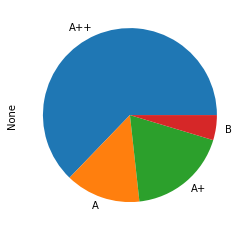

In [66]:
pd.Series(eneffklasse).plot(kind="pie")

Thats nice, let's define a function that takes a column name as a
parameter, counts the occurances and plots the resul

In [67]:
def count(col_name, project_dict=projects):
    if col_name not in project_dict[0]["properties"]:
        raise KeyError(f"{col_name=} not in projects variables")
    count = [p["properties"][col_name] for p in project_dict]
    count = [c for c in count if c is not None]
    return Counter(count)

In [68]:
projects[0]["properties"]

{'OBJECTID': 51642,
 'ID': 146,
 'BEZEICHNUNG': 'Tunnelthermie Sportmittelschule Hadersdorf',
 'KATEGORIE': 'Energieerzeugung',
 'SUBKATEGORIE': 'Umweltwärme/Wärmepumpen',
 'BESCHREIBUNG_KURZ': '2004 startete in Wien-Hadersdorf ein Pilotprojekt zur Erprobung von „Tunnelthermie“. Seither wird ein Schulgebäude mit Wärme aus dem Lainzer Tunnel versorgt.',
 'BESCHREIBUNG': '<p>Als in den 2000er-Jahren der neue Lainzer Eisenbahntunnel im Westen Wiens errichtet wurde, sollte ein Teil der Infrastruktur zur Erprobung einer noch jungen Technologie genutzt werden: Sogenannte „Tunnelthermie“ nützt die massiven, in den Untergrund eingebetteten Betonbauteile von Verkehrstunneln und macht deren enorme thermische Speicherfähigkeit verfügbar („Aktivierung“). Dazu werden Bohrpfähle, Tunnelwände usw. mit Rohrleitungen versehen, in denen eine Wärmeträgerflüssigkeit zirkuliert, die dem angrenzenden Erdreich Wärme entzieht. Dabei wird der geothermische Umstand genützt, dass die Temperaturen im Boden ab ein

<AxesSubplot:>

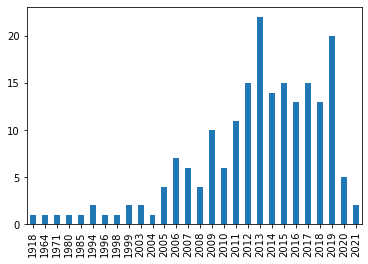

In [69]:
pd.Series(count("BAUJAHR")).sort_index().plot(kind="bar")

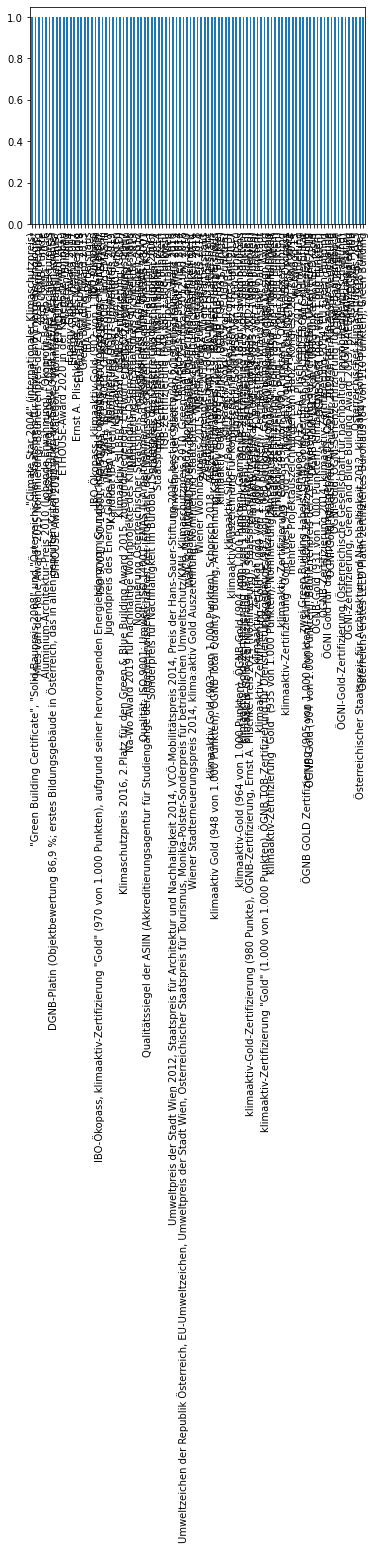

In [70]:
def plot_cat(col_name, kind="bar"):
    pd.Series(count(col_name)).sort_index().plot(kind=kind)

plot_cat("EEFF_ZERTIFIKAT")

uh... there is data on certificates there, but it is unsorted

In [71]:
HWB = df[df.EEFF_HWB.notnull()]
HWB.EEFF_HWB = [x.replace(",",".") for x in HWB.EEFF_HWB]
HWB.EEFF_HWB = HWB.EEFF_HWB.astype(float)
HWB.EEFF_HWB.sort_values()

C:\Users\Simon Schneider\anaconda\envs\MEE1-3-PEQ\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


19         3.00
155        3.40
15         5.11
36         5.80
25         5.82
         ...   
28        39.09
31        42.00
46        44.00
139       50.89
6      30935.00
Name: EEFF_HWB, Length: 89, dtype: float64

In [72]:
for col_name, col_val in zip(HWB.columns,HWB.loc[60]):
    if pd.notnull(col_val):
        print(f"{col_name[:20]:20s}: {col_val}")

KeyError: 60

this is getting a little untidy. let's try to restructure the data in a useful way.
let's flatten the dictionary - adding all properties directly to the first level.

In [ ]:
for p in projects:
    props = p.pop("properties")
    p.update(**props)


projects

In [ ]:
def column_counters(project_list):
    counters = {}
    for key in project_list[0]:
        l = [project[key] for project in project_list]
        c = Counter(l)
        counters[key] = c
    return counters

project_counters = column_counters(projects)

In [ ]:
def count2(col_name, project_dict=projects):
    if col_name not in project_dict[0]["properties"]:
        raise KeyError(f"{col_name=} not in projects variables")
    count = [p["properties"][col_name] for p in project_dict]
    count = [c for c in count if c is not None]
    return Counter(count)

1. Get the water quality of Austrian lakes from here https://www.ages.at/typo3temp/badegewaesser_db.json and print all the latest available data for Viennese water bodies in a comprehensive form

1. Browse https://www.data.gv.at/?s=json for more interesting datasets